In [23]:
import matplotlib.pyplot as plt
import requests
from thesportsdb.TheSportsDbRepository import *
from thesportsdb.Cleaner import *
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor,GradientBoostingClassifier,RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from thesportsdb.Modelization import *
from thesportsdb.Cleaner import *
from thesportsdb.Predictor import *
from thesportsdb.TheSportsDbRepository import *
import pandas as pd
from thesportsdb.StaticInfos import StaticInfos


<h1>Formation du dataframe à partir de l'api thesportsdb </h1>

In [24]:
nextRoundId = getNextRoundId() - 1
matchsForRound = (getEventRoundForLigue(StaticInfos.ligue1Id, nextRoundId))
df = pd.DataFrame(matchsForRound)
df = cleanEvents(df)
dfTotal = pd.DataFrame()
load5LastMatchs(nextRoundId)
for i in range(0, len(df)):
    match = df.iloc[i]
    awayDataframe = getDataframe(int(match['idAwayTeam']))
    homeDataframe = getDataframe(int(match['idHomeTeam']))
    if dfTotal.empty:
        dfTotal = pd.concat([awayDataframe, homeDataframe])
    else:
        dfMatch = pd.concat([awayDataframe, homeDataframe])
        dfTotal = pd.concat([dfTotal, dfMatch])

5 Premières lignes et les clés du tableau

In [25]:
print(dfTotal.keys())
dfTotal.head()

Index(['score5LastMatchs', 'goalAverageLast5Matchs', 'last5MatchsScoredGoals',
       'last5MatchsConcededGoals', 'last5MatchsWins', 'last5MatchsLoss',
       'opponentScore5LastMatchs', 'opponentGoalAverageLast5Matchs',
       'opponentLast5MatchsScoredGoals', 'opponentLast5MatchsConcededGoals',
       'opponentLast5MatchsWins', 'opponentLast5MatchsLoss', 'isHome',
       'isWinning', 'scoredGoals', 'concededGoals', 'nameTeam',
       'opponentNameTeam'],
      dtype='object')


,score5LastMatchs,goalAverageLast5Matchs,last5MatchsScoredGoals,last5MatchsConcededGoals,last5MatchsWins,last5MatchsLoss,opponentScore5LastMatchs,opponentGoalAverageLast5Matchs,opponentLast5MatchsScoredGoals,opponentLast5MatchsConcededGoals,opponentLast5MatchsWins,opponentLast5MatchsLoss,isHome,isWinning,scoredGoals,concededGoals,nameTeam,opponentNameTeam
0,86.666667,5,9,4,4,0,86.666667,7,8,1,4,0,0,0,0,4,Lens,Lille
1,66.666667,2,8,6,3,1,66.666667,3,8,5,3,1,1,1,2,0,Lens,St Etienne
2,60.000000,2,7,5,3,1,26.666667,1,7,6,1,2,0,0,1,1,Lens,Nimes
3,40.000000,1,5,4,2,1,33.333333,2,2,0,1,0,1,1,2,1,Lens,Bordeaux
4,20.000000,0,2,2,1,1,20.000000,0,3,3,1,1,0,1,3,2,Lens,Lorient


Chance qu'une équipe l'emporte par rapport à sa série de défaite
On observe que les équipes qui ne perdent pas s'en sortent le mieux
Toutefois, Certaines équipes arrivent à se sortir d'une mauvaise série, notammenent celles qui ont eu 3 défaites sur les derniers matchs

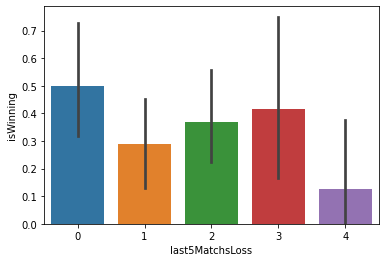

In [26]:
sns.barplot(x='last5MatchsLoss', y= 'isWinning', data=dfTotal)
plt.show()

<h2>Entrainement du modèle avec le RandomForestClassifier

In [27]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import  train_test_split
X = dfTotal[['isWinning', 'isHome', 'last5MatchsWins', 'last5MatchsLoss','opponentGoalAverageLast5Matchs' ,'last5MatchsConcededGoals', 'opponentLast5MatchsLoss', 'opponentLast5MatchsWins','opponentLast5MatchsConcededGoals','opponentLast5MatchsScoredGoals',
                 'last5MatchsScoredGoals', 'score5LastMatchs', 'goalAverageLast5Matchs', 'opponentScore5LastMatchs']]
y = dfTotal['isWinning']
del X['isWinning']
x_train, x_val, y_train, y_val = train_test_split(X,y,test_size=0.2)
from sklearn.metrics import accuracy_score
cls = RandomForestClassifier(n_estimators=200, max_depth=2).fit(x_train, y_train)
score = cls.score(x_val, y_val)
filename = StaticInfos.pickleFileName
pickle.dump(cls, open(filename, 'wb'))
print(score)

0.6


<p>Résultat assez moyen, il manque des lignes au dataset initial (seulement  100), mais les données de cette api sont limitées
<p>Une source de données avec un nombre de renseignements plus important aurait été préférable ainsi qu'avec des données plus singulières telles que la note des joueurs de chaque équipe

Test de prédiction à partir de deux identifiants d'équipe

In [28]:
opposition = getNextMatchDataframe('133822', '133707', type)

In [29]:
cls = pickle.load(open("L1_predict.pkl", "rb"))
x_predictor = opposition[
        ['isHome', 'last5MatchsWins', 'last5MatchsLoss', 'opponentGoalAverageLast5Matchs',
          'last5MatchsConcededGoals', 'opponentLast5MatchsLoss', 'opponentLast5MatchsWins',
          'opponentLast5MatchsConcededGoals', 'opponentLast5MatchsScoredGoals',
          'last5MatchsScoredGoals', 'score5LastMatchs', 'goalAverageLast5Matchs', 'opponentScore5LastMatchs']]
(cls.predict_proba(x_predictor)).max()

0.7272068777612029

L'équipe 133822 est favoris pour ce match

 <h2>Matrice de confusion</h1>
<p>On observe que le modèle peut se tromper

In [30]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val, cls.predict(x_val))


array([[12,  2],
       [ 6,  0]])